#

In [ ]:

import boto3
import pandas as pd
from io import StringIO

def load_all_csvs_from_s3(bucket_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)

    dfs = []  # an empty list to store the data frames

    for obj in bucket.objects.all():
        if obj.key.endswith('.csv'):  # to ensure the file is a csv file
            data = obj.get()['Body'].read().decode('utf-8')  # get the file data
            df = pd.read_csv(StringIO(data))  # read the CSV data as a data frame
            dfs.append(df)  # append the data frame to the list

    final_df = pd.concat(dfs, ignore_index=True)  # concatenate all the data frames in the list

    return final_df

df = load_all_csvs_from_s3('dipy-parallel-tests')

/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_9125/392492796.py:25: FutureWarning: The provided callable <function mean at 0x106401080> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_df = cpu_df.groupby('num_chunks')['time'].agg([np.mean, np.std]).reset_index()
/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_9125/392492796.py:25: FutureWarning: The provided callable <function std at 0x1064011c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  grouped_df = cpu_df.groupby('num_chunks')['time'].agg([np.mean, np.std]).reset_index()
/var/folders/gb/604kkgfn2cj2q1bp1zw3t56m0000gn/T/ipykernel_9125/392492796.py:25: FutureWarning: The provided callable <function mean at 0x106401080> is currently using SeriesGroupBy.m

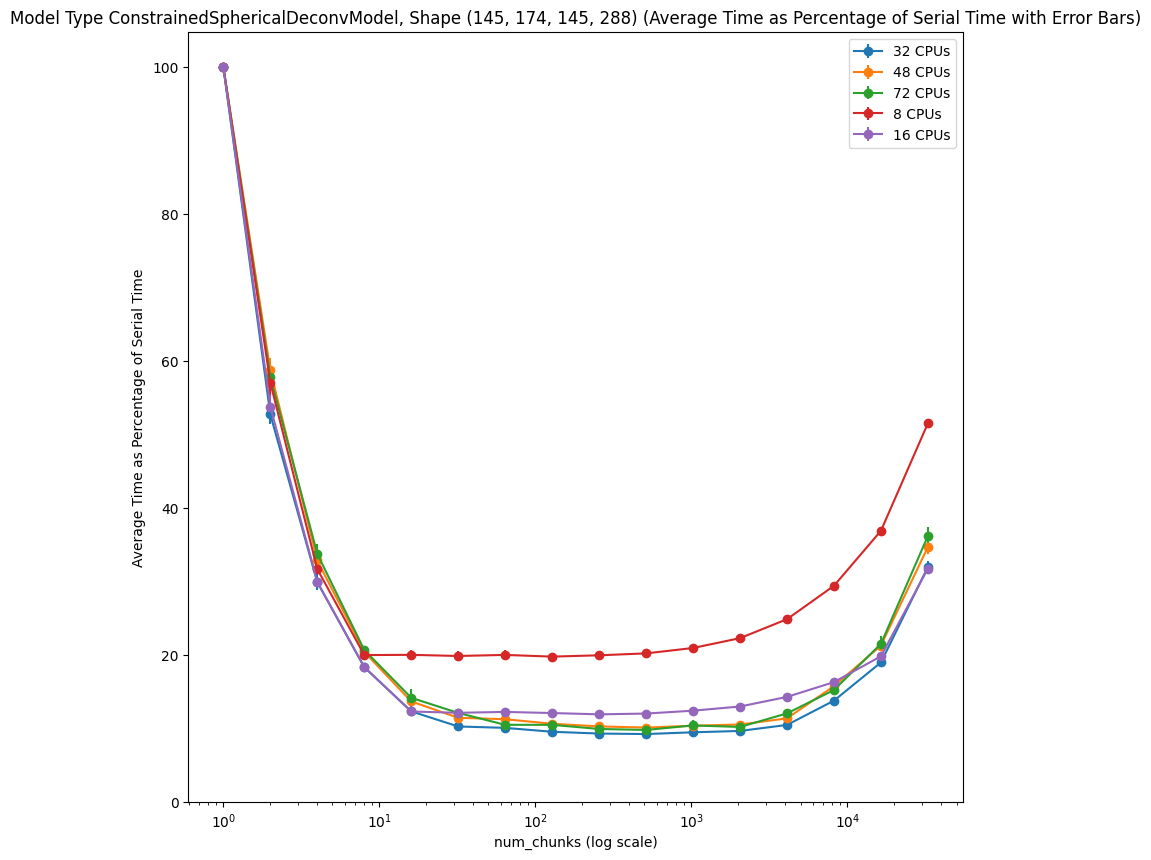

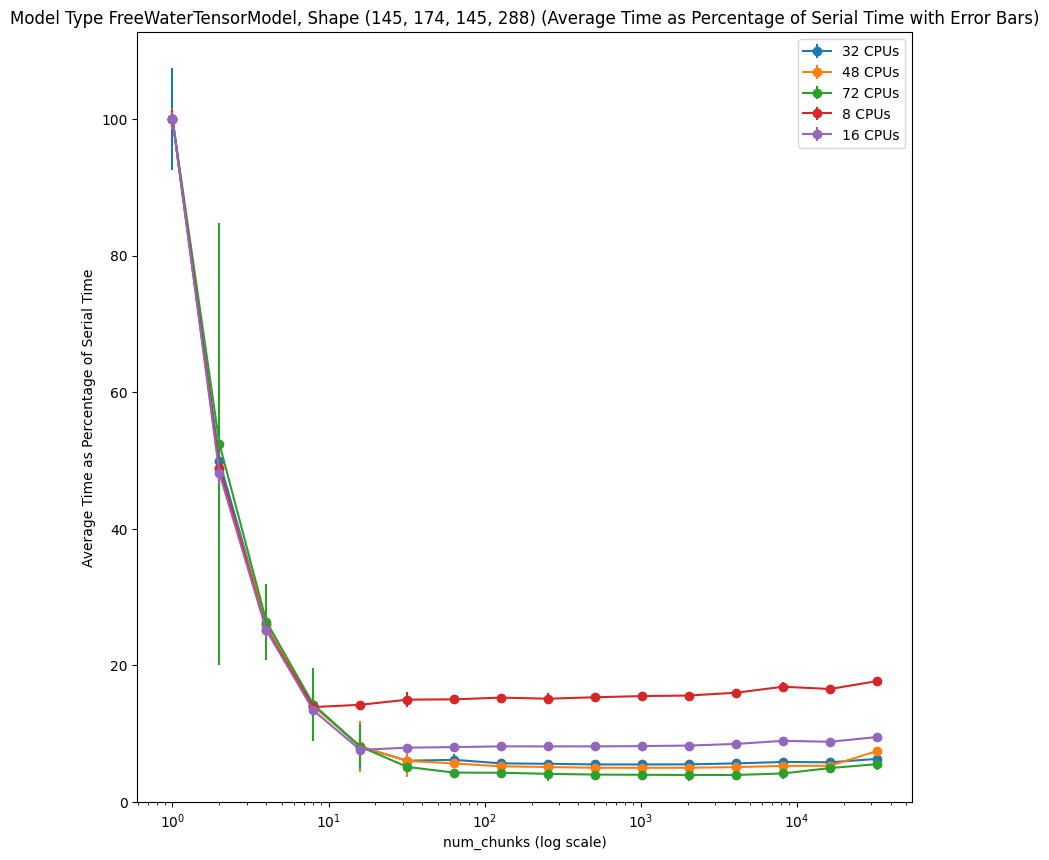

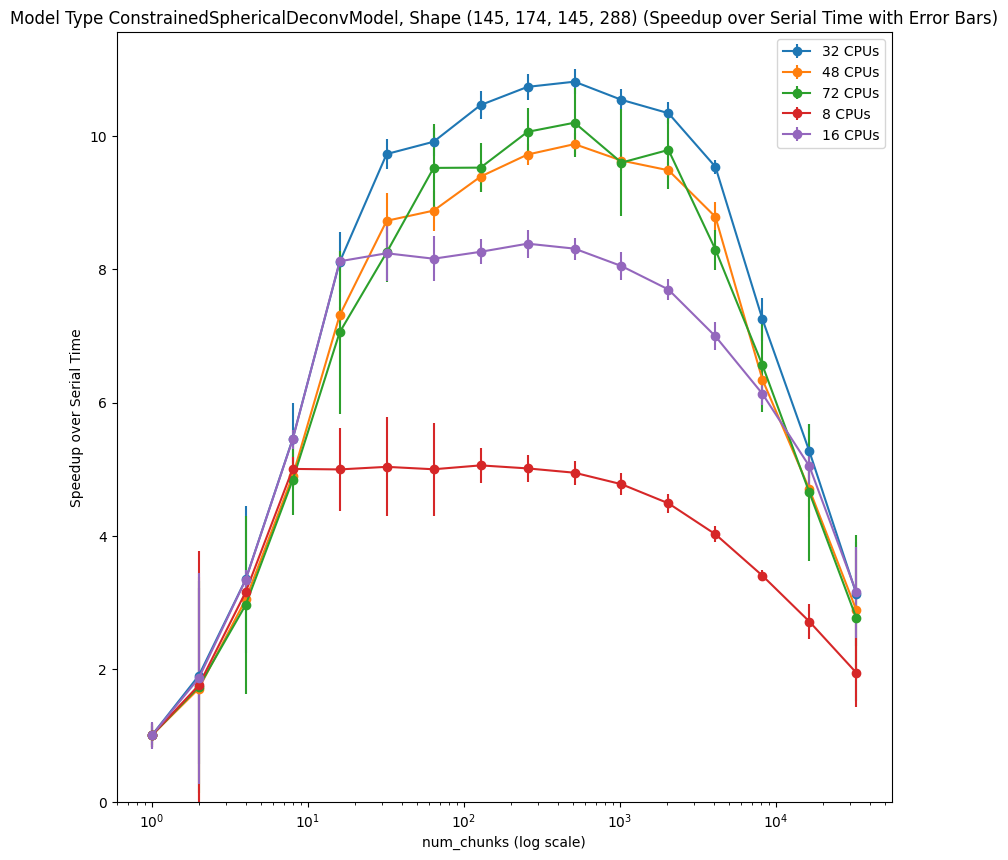

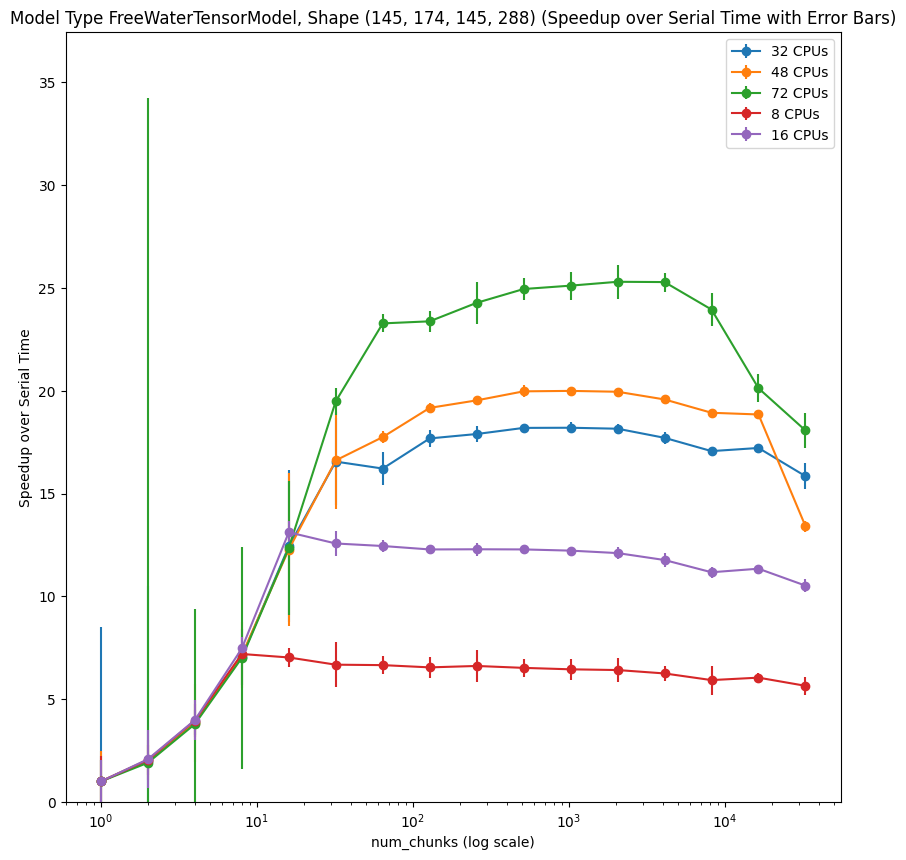

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

shapes = df['data_shape'].unique()

for shape in shapes:
    shape_df = df[df['data_shape'] == shape]
    models = shape_df['model'].unique()

    for model in models:
        model_df = shape_df[shape_df['model'] == model]

        cpu_counts = model_df['cpu_count'].unique()

        fig, ax = plt.subplots(figsize=(10, 10))

        for cpu_count in cpu_counts:
            cpu_df = model_df[model_df['cpu_count'] == cpu_count]

            # Calculate the average time of the serial runs
            serial_avg_time = cpu_df[cpu_df['engine'] == 'serial']['time'].mean()

            # Group by 'num_chunks' and calculate the mean and std of 'time'
            grouped_df = cpu_df.groupby('num_chunks')['time'].agg([np.mean, np.std]).reset_index()

            # Express the time of the ray runs as a percentage of the average serial time
            grouped_df['mean'] = grouped_df['mean'].apply(lambda x: (x / serial_avg_time) * 100 if serial_avg_time else 0)

            ax.errorbar(grouped_df['num_chunks'], grouped_df['mean'], yerr=grouped_df['std'], label=f'{cpu_count} CPUs', fmt='-o')

        ax.set_xscale('log')
        ax.set_ylim(bottom=0)

        ax.set_title(f'Model Type {model}, Shape {shape} (Average Time as Percentage of Serial Time with Error Bars)')
        ax.set_xlabel('num_chunks (log scale)')
        ax.set_ylabel('Average Time as Percentage of Serial Time')
        ax.legend()  # Add a legend
        plt.show()

for shape in shapes:
    shape_df = df[df['data_shape'] == shape]
    models = shape_df['model'].unique()

    for model in models:
        model_df = shape_df[shape_df['model'] == model]
        cpu_counts = model_df['cpu_count'].unique()

        fig, ax = plt.subplots(figsize=(10, 10))

        for cpu_count in cpu_counts:
            cpu_df = model_df[model_df['cpu_count'] == cpu_count]

            # Calculate the average time of the serial runs
            serial_avg_time = cpu_df[cpu_df['engine'] == 'serial']['time'].mean()

            # Group by 'num_chunks' and calculate the mean and std of 'time'
            grouped_df = cpu_df.groupby('num_chunks')['time'].agg([np.mean, np.std]).reset_index()

            # Calculate the speedup as the ratio of the serial time to the ray time
            grouped_df['mean'] = grouped_df['mean'].apply(lambda x: serial_avg_time / x if x else 0)

            ax.errorbar(grouped_df['num_chunks'], grouped_df['mean'], yerr=grouped_df['std'], label=f'{cpu_count} CPUs', fmt='-o')

        ax.set_xscale('log')
        ax.set_ylim(bottom=0)

        ax.set_title(f'Model Type {model}, Shape {shape} (Speedup over Serial Time with Error Bars)')
        ax.set_xlabel('num_chunks (log scale)')
        ax.set_ylabel('Speedup over Serial Time')
        ax.legend()  # Add a legend
        plt.show()
